# Neighborhoods in Toronto

#### This project is an assignment of Applied Data Science Capstone. We use Foursquare API to study the neighborhoods of each postal region in Toronto.

In [9]:
import requests
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe




### Scrape from the webpage https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [10]:
"""scrape from webpage"""
from bs4 import BeautifulSoup

URL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

### Transform the data into a pandas dataframe

In [11]:
#locate the table
table = soup.find('table', class_="wikitable sortable")

#convert table to a list with each element of the form [PostalCode, Borough, Neighborhood]
table_str = str(table)
table_str = table_str.split('</th></tr>\n')[1]
table_str = table_str.split('</td></tr>\n')

for i in range(len(table_str)):
    table_str[i] = table_str[i].replace('\n', '')
    table_str[i] = table_str[i].replace('<tr><td>', '')
    table_str[i] = table_str[i].split('</td><td>')
    
table_str[-1][2] = table_str[-1][2].replace('</td></tr></tbody></table>','')


#extract those rows with Borough not equal to 'Not assigned'
PostalCode = []
Borough = []
Neighborhood = []

for i in range(len(table_str)):
    if table_str[i][1] != 'Not assigned':  #Borough
        PostalCode.append(table_str[i][0])
        Borough.append(table_str[i][1])
        if table_str[i][2] != 'Not assigned':  #Neighborhood
            Neighborhood.append(table_str[i][2])
        else:
            Neighborhood.append(table_str[i][1])  #if Neighborhood is 'Not assigned', then use Borough instead
            #print(table_str[i])
    #else:
        #print(table_str[i])
        
#construct a pandas dataframe
df_neigh = pd.DataFrame({'PostalCode': PostalCode, 'Borough':Borough, 'Neighborhood':Neighborhood})
df_neigh.head(12)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


pip install geocoder --yes

In [12]:
import geocoder # import geocoder

"""
Input: postalcode of Toronto
Output: [latitude, logitude]
"""

def get_coords(postal_code):
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
        print(g)
    
    return lat_lng_coords

In [13]:
#load coordinates by Postal Code from outside source
df_coords = pd.read_csv('http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv')
df_coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Add coordinates to the dataframe

In [14]:
#df_neigh left join with df_coords
df_loc = pd.merge(df_neigh, df_coords, how='left', left_on = 'PostalCode', right_on = 'Postal Code')
df_loc.drop('Postal Code', axis = 1, inplace = True)
print('There are {} null values in coordinates'.format(df_loc.Latitude.isnull().sum()))
df_loc.head(12)

There are 0 null values in coordinates


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


### Explore venues from Foursquare.com

In [15]:
CLIENT_ID = 'VTJNOAJ0MRFRMDXPNCBKT5EW50DFI2ORQURO3J40CUNLSWSP' # your Foursquare ID
CLIENT_SECRET = 'D0MQ1UJYWGP1OAYLZ3FFKEMQ0FOOT0FIYB3IWNL4CLNBAISQ' # your Foursquare Secret
access_token = "0OB3TZL1N4BHJY2MSPCEDO21AKZEIOV4VN0FLFTZZAFHUXSM"
VERSION = '20200605' # Foursquare API version

CLIENT_ID = "4UFZAFUMNFADWCHWO2WWR1NJFL2Q1044QF2BEDOQXFJGW4DR"
CLIENT_SECRET = 'U2NJO2GETDVFUOPVCS4Z55YN2DVYWKWJ1ODYOVB10JQIMQY3' # your Foursquare Secret
access_token = "1PEXJX21MBZ1NF1XCCXY4IBKN30UZPU01ZFBVZOHQKNHFEMY"
VERSION = '20200605' # Foursquare API version

In [16]:
#get json file of venues for the given postal code with the given location dataframe df_loc
def postal_to_VenuesJson(postal_code):
    LIMIT = 100
    radius = 500

    lat = df_loc.loc[df_loc.PostalCode == postal_code, 'Latitude'].values[0]
    lng = df_loc.loc[df_loc.PostalCode == postal_code, 'Longitude'].values[0]
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)
    return requests.get(url).json()


In [17]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
postal_code = 'M5A'
results = postal_to_VenuesJson(postal_code)

venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print('Nearby venues for postal code {}'.format(postal_code))
nearby_venues.head()

Nearby venues for postal code M5A


,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
3,Body Blitz Spa East,Spa,43.654735,-79.359874
4,Dominion Pub and Kitchen,Pub,43.656919,-79.358967


In [19]:
#get categories distribution from json data, return a series with category type and percentage
def get_category_distribution(results):
    venues = results['response']['groups'][0]['items']
    df_venues = pd.json_normalize(venues)
    categories = df_venues.apply(get_category_type, axis=1)
    return categories.value_counts(True)

In [23]:
#get distribution dataframe for all postal districts
df_cat = pd.DataFrame(columns = ['categories'])

for postal_code in df_loc['PostalCode']:
    #get json data from foursquare.com
    results = postal_to_VenuesJson(postal_code)
    #get categories distribution dataframe from json data
    try:
        df_temp = pd.DataFrame(get_category_distribution(results), columns = [postal_code]).reset_index()
        df_temp.rename(columns = {'index':'categories'}, inplace = True)
        #update df_cat by outer join with df_temp
        df_cat = df_cat.merge(df_temp, how = 'outer', on = 'categories')
    except:
        print('Run out of free calls, {} postal regions is missing.'.format(postal_code))
        #counts =  df_loc['PostalCode'][df_loc['PostalCode'] == postal_code].index[0]
        #print('Run out of free calls, {} postal regions\' data have been loaded.'.format(counts))
    
#replace null value with 0
df_cat.replace(np.nan, 0, inplace = True)

Run out of free calls, M9A postal regions is missing.
Run out of free calls, M4G postal regions is missing.
Run out of free calls, M2M postal regions is missing.
Run out of free calls, M1X postal regions is missing.


In [42]:
#arrange df_cat and store it to df_cat1
df_cat1 = df_cat.set_index('categories')
df_cat1.index.name = None
df_cat1 = df_cat1.T.reset_index()
df_cat1.rename(columns = {'index':'PostalCode'}, inplace = True)
df_cat1.head()

,PostalCode,Construction & Landscaping,Food & Drink Shop,Park,French Restaurant,Pizza Place,Hockey Arena,Portuguese Restaurant,Coffee Shop,Pub,...,Flower Shop,Health & Beauty Service,Cafeteria,Skate Park,Auto Workshop,Garden Center,Wings Joint,Kids Store,Social Club,Hardware Store
0,M3A,0.333333,0.333333,0.333333,0.000000,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M4A,0.000000,0.000000,0.000000,0.200000,0.2,0.2,0.2,0.200000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M5A,0.000000,0.000000,0.063830,0.021277,0.0,0.0,0.0,0.170213,0.06383,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M6A,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.090909,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M7A,0.000000,0.000000,0.031250,0.000000,0.0,0.0,0.0,0.218750,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
df_cat1.shape

(99, 273)

### Use PCA to visualize the data to decide how many clusters needed

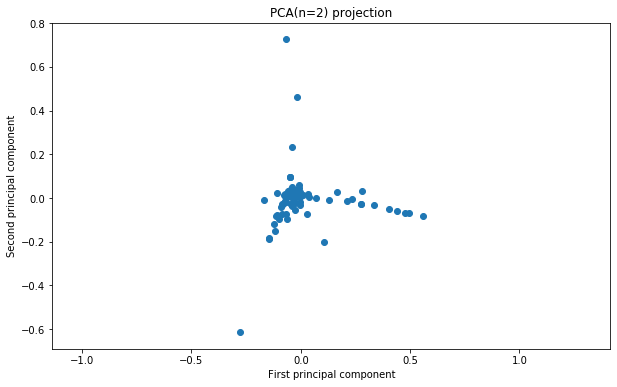

In [56]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = np.array(df_cat1.iloc[:,1:])

pca = PCA(n_components = 2)
pca.fit(X)
X_reduced = pca.transform(X)

#plot the results of PCA
plt.figure(figsize = [10,6])
plt.scatter(X_reduced[:,0], X_reduced[:,1])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.axis('equal')
plt.title('PCA(n=2) projection')
plt.show()

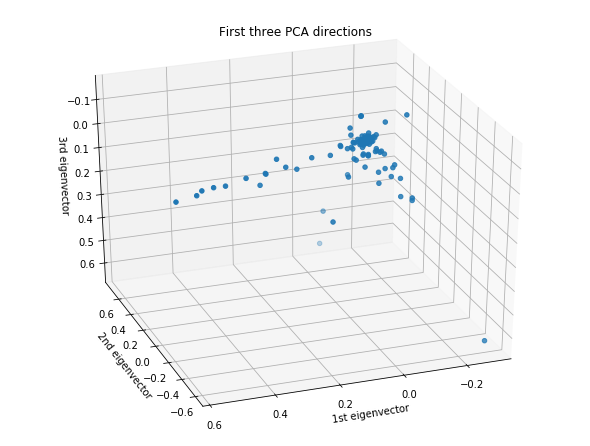

In [58]:
from mpl_toolkits.mplot3d import Axes3D

X = np.array(df_cat1.iloc[:,1:])

#PCA, n=3
pca3 = PCA(n_components = 3)
pca3.fit(X)
X_reduced3 = pca3.transform(X)

#plot the PCA
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_reduced3[:,0],X_reduced3[:,1],X_reduced3[:,2])

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
#ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
#ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
#ax.w_zaxis.set_ticklabels([])
    
plt.show()

### K-means Clustering and Visualization

In [63]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

In [72]:
df_cat1.insert(0, 'Cluster Labels', kmeans.labels_)
df_cl = df_cat1[['PostalCode','Cluster Labels']].merge(df_loc, on = 'PostalCode')
df_cl.head()

,PostalCode,Cluster Labels,Borough,Neighborhood,Latitude,Longitude
0,M3A,0,North York,Parkwoods,43.753259,-79.329656
1,M4A,1,North York,Victoria Village,43.725882,-79.315572
2,M5A,1,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,1,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [61]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [75]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [82]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = ['#ff0000', '#ffa500', 'green', 'blue', 'purple']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_cl['Latitude'], df_cl['Longitude'],df_cl['Neighborhood'], df_cl['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [90]:
df_group = df_cat1.groupby(['Cluster Labels']).mean()
df_group

,Construction & Landscaping,Food & Drink Shop,Park,French Restaurant,Pizza Place,Hockey Arena,Portuguese Restaurant,Coffee Shop,Pub,Bakery,...,Flower Shop,Health & Beauty Service,Cafeteria,Skate Park,Auto Workshop,Garden Center,Wings Joint,Kids Store,Social Club,Hardware Store
Cluster Labels,,,,,,,,,,,,,,,,,,,,,
0,0.033333,0.033333,0.400000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.002667,0.002309,0.020147,0.005019,0.023266,0.006,0.002667,0.064511,0.010030,0.022304,...,0.00105,0.000161,0.000161,0.000784,0.000784,0.000784,0.000889,0.000889,0.000889,0.000889
2,0.000000,0.000000,0.025000,0.000000,0.259803,0.000,0.000000,0.036264,0.039286,0.025000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.166667,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [100]:
#create a list of average of each categories
ave_list = []
for cat in df_group.columns:
    ave_list.append(df_group[cat].mean())

#return the indexes of top10 average
ave_list = np.array(ave_list)
top10 = np.argsort(-ave_list)[0:10]  #use -ave_list (negative) to get the descending order
ave_list[top10]

array([0.20004444, 0.11670588, 0.08902944, 0.05661383, 0.04053333,
       0.03042267, 0.02314434, 0.02015499, 0.01864834, 0.0177234 ])

In [99]:
df_group.iloc[:,top10]

,Filipino Restaurant,Baseball Field,Park,Pizza Place,Construction & Landscaping,Fast Food Restaurant,Convenience Store,Coffee Shop,Sandwich Place,Playground
Cluster Labels,,,,,,,,,,
0,0.000000,0.000000,0.400000,0.000000,0.033333,0.000000,0.100000,0.000000,0.000000,0.075000
1,0.000222,0.000196,0.020147,0.023266,0.002667,0.007995,0.008579,0.064511,0.019478,0.013617
2,0.000000,0.000000,0.025000,0.259803,0.000000,0.144118,0.007143,0.036264,0.073764,0.000000
3,0.000000,0.583333,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [106]:
#downtown belongs to cluster 1, find the top 10 categories in cluster 1
df_group.iloc[1].sort_values(ascending = False)[0:10]

Coffee Shop       0.064511
Café              0.038940
Pizza Place       0.023266
Bakery            0.022304
Bar               0.021914
Grocery Store     0.021191
Restaurant        0.020345
Park              0.020147
Sandwich Place    0.019478
Bank              0.018563
Name: 1, dtype: float64